In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Load data
df = pd.read_csv("daftar-harga-rumah-jabodetabek.csv")

df.head()

,url,price_in_rp,title,address,district,city,lat,long,facilities,property_type,...,electricity,maid_bedrooms,maid_bathrooms,floors,building_age,year_built,property_condition,building_orientation,garages,furnishing
0,https://www.rumah123.com/properti/bekasi/hos11...,2.990000e+09,Rumah cantik Sumarecon Bekasi\nLingkungan asri...,"Summarecon Bekasi, Bekasi",Summarecon Bekasi,Bekasi,-6.223945,106.986275,"Tempat Jemuran, Jalur Telepon, Taman, Taman",rumah,...,4400 mah,0.0,1.0,2.0,5.0,2017.0,bagus,NaN,0.0,unfurnished
1,https://www.rumah123.com/properti/bekasi/hos10...,1.270000e+09,"Rumah Kekinian, Magenta Summarecon Bekasi","Summarecon Bekasi, Bekasi",Summarecon Bekasi,Bekasi,-6.223945,106.986275,Taman,rumah,...,2200 mah,0.0,0.0,2.0,NaN,NaN,bagus,NaN,0.0,NaN
2,https://www.rumah123.com/properti/bekasi/hos10...,1.950000e+09,Rumah Cantik 2 Lantai Cluster Bluebell Summare...,"Summarecon Bekasi, Bekasi",Summarecon Bekasi,Bekasi,-6.223945,106.986275,"Jogging Track, Kolam Renang, Masjid, Taman,...",rumah,...,2200 mah,1.0,1.0,2.0,NaN,NaN,bagus,NaN,1.0,unfurnished
3,https://www.rumah123.com/properti/bekasi/hos10...,3.300000e+09,Rumah Mewah 2Lantai L10x18 C di Cluster VERNON...,"Summarecon Bekasi, Bekasi",Summarecon Bekasi,Bekasi,-6.223945,106.986275,"Jalur Telepon, Jogging Track, Track Lari, K...",rumah,...,3500 mah,1.0,1.0,2.0,6.0,2016.0,bagus sekali,utara,2.0,unfurnished
4,https://www.rumah123.com/properti/bekasi/hos10...,4.500000e+09,"Rumah Hoek di Cluster Maple Summarecon Bekasi,...","Summarecon Bekasi, Bekasi",Summarecon Bekasi,Bekasi,-6.223945,106.986275,"Jogging Track, Kolam Renang, Taman, Jalur Te...",rumah,...,3500 mah,1.0,1.0,2.0,9.0,2013.0,bagus,utara,1.0,unfurnished


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3553 entries, 0 to 3552
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   url                   3553 non-null   object 
 1   price_in_rp           3553 non-null   float64
 2   title                 3553 non-null   object 
 3   address               3553 non-null   object 
 4   district              3553 non-null   object 
 5   city                  3553 non-null   object 
 6   lat                   3553 non-null   float64
 7   long                  3553 non-null   float64
 8   facilities            3553 non-null   object 
 9   property_type         3552 non-null   object 
 10  ads_id                3549 non-null   object 
 11  bedrooms              3519 non-null   float64
 12  bathrooms             3524 non-null   float64
 13  land_size_m2          3551 non-null   float64
 14  building_size_m2      3551 non-null   float64
 15  carports             

In [4]:
# Gabungkan kolom bedrooms dan maid_bedrooms
df['bedrooms'] = df['bedrooms'] + df['maid_bedrooms']
df = df.drop(columns=['maid_bedrooms'])

# Gabungkan kolom bathrooms dan maid_bathrooms
df['bathrooms'] = df['bathrooms'] + df['maid_bathrooms']
df = df.drop(columns=['maid_bathrooms'])

In [5]:
# Hapus kolom yg tidak relevan
drop_cols = ["url", "title", "address", "ads_id"]
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

In [6]:
# Cek missing value
missing_value = df.isnull().mean()
missing_value


price_in_rp             0.000000
district                0.000000
city                    0.000000
lat                     0.000000
long                    0.000000
facilities              0.000000
property_type           0.000281
bedrooms                0.009569
bathrooms               0.008162
land_size_m2            0.000563
building_size_m2        0.000563
carports                0.000000
certificate             0.039685
electricity             0.000000
floors                  0.001689
building_age            0.406699
year_built              0.406699
property_condition      0.069237
building_orientation    0.463552
garages                 0.000000
furnishing              0.108922
dtype: float64

In [7]:
# Karena miss value tdk terlalu tinggi (tdk mencapai 80%), maka perlu mengisi missing value
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('price_in_rp')
categorical_cols = df.select_dtypes(include=['object']).columns

for col in numerical_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

for col in categorical_cols:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)

In [8]:
# Hapus outlier
for col in numerical_cols:
    q99 = df[col].quantile(0.99)
    df = df[df[col] <= q99]

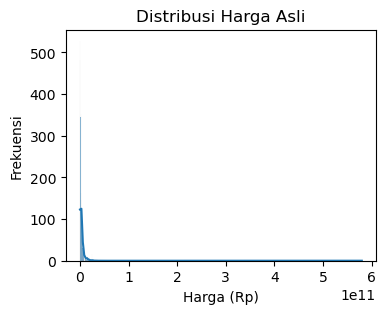

Skewness: 44.97353101021652


In [9]:
# Lihat data skewed/tidak
plt.figure(figsize=(4, 3))
sns.histplot(df["price_in_rp"], kde=True)
plt.title("Distribusi Harga Asli")
plt.xlabel("Harga (Rp)")
plt.ylabel("Frekuensi")
plt.show()

skew_value = df["price_in_rp"].skew()
print("Skewness:", skew_value)

In [10]:
# Menggunakan log supaya tidak terlalu skew
df['log_price'] = np.log(df['price_in_rp'])

In [11]:
print(df["log_price"].skew())

0.45794851664952246


Fitur numerik dengan korelasi > 0.3 terhadap log_price:
building_size_m2    0.816643
bathrooms           0.805961
bedrooms            0.758779
land_size_m2        0.696980
floors              0.531719
price_in_rp         0.398886
carports            0.324314
Name: log_price, dtype: float64


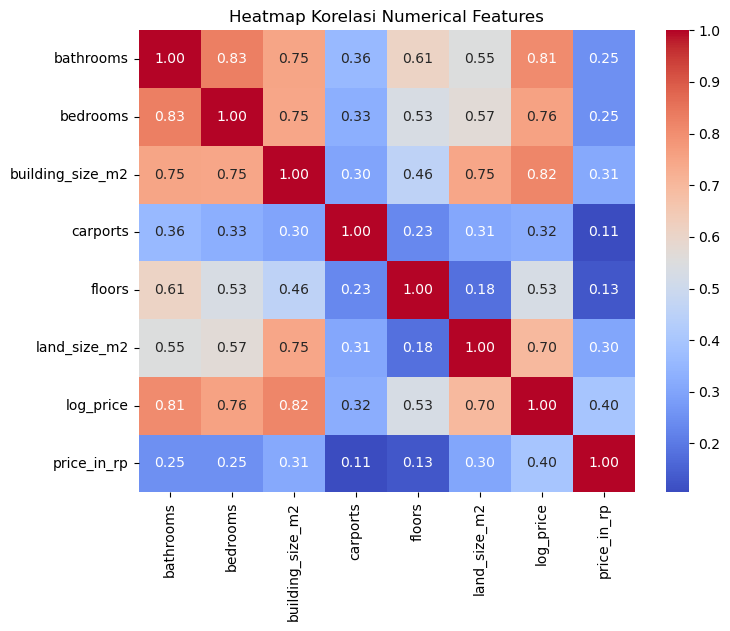

In [12]:
numerical_cols = df.select_dtypes(include=['float64']).columns.tolist()

# Hitung korelasi antar fitur numerik
corr_matrix = df[numerical_cols].corr()

# Korelasi fitur terhadap target log_price
corr_target = corr_matrix['log_price'].drop('log_price')

# Tampilkan fitur dengan korelasi absolut > 0.3
selected_features = corr_target[abs(corr_target) > 0.3].sort_values(ascending=False)
print("Fitur numerik dengan korelasi > 0.3 terhadap log_price:")
print(selected_features)

# Visualisasi heatmap korelasi fitur vs target
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix.loc[selected_features.index.union(['log_price']), selected_features.index.union(['log_price'])],
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap Korelasi Numerical Features")
plt.show()

In [13]:
num_cols = ["land_size_m2", "building_size_m2", "bedrooms", "bathrooms", "floors", "carports"]
cat_onehot = ['city']
cat_target = ['district']
cat_cols = cat_onehot + cat_target

In [14]:
# Model - Linear Regression
# Buat preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("city_enc", OneHotEncoder(handle_unknown='ignore'), cat_onehot),
        ("district_enc", TargetEncoder(), cat_target),
    ])

# Buat pipeline model
model_lin = Pipeline(steps=[
    ("prep", preprocessor),
    ("linreg", LinearRegression())
])

In [15]:
# Model - Polynomial Regression (Degree 2)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

# Preprocessor (sama)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("city_enc", OneHotEncoder(handle_unknown='ignore'), cat_onehot),
        ("district_enc", TargetEncoder(), cat_target),
    ])

# Pipeline Polynomial
model_poly2 = Pipeline(steps=[
    ("prep", preprocessor),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("reg", Ridge(alpha=100.0))
])

In [16]:
# Model - Logarithmic Regression

from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

# Custom transformer untuk log(X)
class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.log1p(X)  # log(1 + x), aman untuk x=0

# Preprocessor: log-transform fitur numerik
preprocessor_logX = ColumnTransformer(transformers=[
    ("log_num", Pipeline([
        ("log", LogTransformer()),
        ("scale", StandardScaler())
    ]), num_cols),
    ("city_enc", OneHotEncoder(handle_unknown='ignore'), cat_onehot),
    ("district_enc", TargetEncoder(), cat_target)
])

# Model pipeline
model_logX = Pipeline(steps=[
    ("prep", preprocessor_logX),
    ("linreg", LinearRegression())
])

In [17]:
# Model - Exponential Regression
# karena harga sudah dlm log_prive maka langsung:
# Pipeline Exponential Regression
model_exp = Pipeline(steps=[
    ("prep", preprocessor),
    ("linreg", LinearRegression())
])

In [18]:
# Train/test split
X = df[cat_cols + num_cols]
y = df["log_price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
def evaluate_model(model, X_train, y_train, X_test, y_test, name="Model"):
    model.fit(X_train, y_train)
    y_pred_log = model.predict(X_test)

    # Coba transform ke harga asli
    y_pred_price = np.exp(y_pred_log)
    y_test_price = np.exp(y_test)

    # Cek apakah ada inf atau NaN
    mask = np.isfinite(y_pred_price) & np.isfinite(y_test_price)

    if not np.all(mask):
        print(f"\n⚠️ Warning: {np.sum(~mask)} prediksi price tidak valid (inf/NaN), di-skip saat evaluasi.\n")

    # Evaluasi di log scale
    r2_log = r2_score(y_test, y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
    mae_log = mean_absolute_error(y_test, y_pred_log)

    # Evaluasi hanya pada nilai yang valid
    r2_price = r2_score(y_test_price[mask], y_pred_price[mask])
    rmse_price = np.sqrt(mean_squared_error(y_test_price[mask], y_pred_price[mask]))
    mae_price = mean_absolute_error(y_test_price[mask], y_pred_price[mask])

    print(f"\n{name}")
    print(f"R² (log):   {r2_log:.4f}  | RMSE (log): {rmse_log:.4f} | MAE (log): {mae_log:.4f}")
    print(f"R² (price): {r2_price:.4f} | RMSE: Rp {rmse_price:,.0f} | MAE: Rp {mae_price:,.0f}")


In [20]:
evaluate_model(model_lin, X_train, y_train, X_test, y_test, "Linear Regression")
evaluate_model(model_poly2, X_train, y_train, X_test, y_test, "Polynomial Degree 2")
evaluate_model(model_logX, X_train, y_train, X_test, y_test, "Logarithmic Regression")
evaluate_model(model_exp, X_train, y_train, X_test, y_test, "Exponential Regression")


Linear Regression
R² (log):   0.8569  | RMSE (log): 0.3870 | MAE (log): 0.2861
R² (price): 0.1470 | RMSE: Rp 4,113,404,899 | MAE: Rp 1,046,296,915

Polynomial Degree 2
R² (log):   0.8913  | RMSE (log): 0.3372 | MAE (log): 0.2480
R² (price): 0.8179 | RMSE: Rp 1,900,746,450 | MAE: Rp 703,842,501

Logarithmic Regression
R² (log):   0.8921  | RMSE (log): 0.3361 | MAE (log): 0.2505
R² (price): 0.7938 | RMSE: Rp 2,022,240,329 | MAE: Rp 719,740,095

Exponential Regression
R² (log):   0.8569  | RMSE (log): 0.3870 | MAE (log): 0.2861
R² (price): 0.1470 | RMSE: Rp 4,113,404,899 | MAE: Rp 1,046,296,915


In [37]:
def estimate_price(sample_dict):
    df_sample = pd.DataFrame([sample_dict])
    log_pred = model_poly2.predict(df_sample)[0]
    price_pred = np.exp(log_pred)
    return price_pred

def estimate_price2(sample_dict):
    df_sample = pd.DataFrame([sample_dict])
    log_pred = model_logX.predict(df_sample)[0]
    price_pred = np.exp(log_pred)
    return price_pred

sample_house = {
    'land_size_m2': 72,
    'building_size_m2': 45,
    'bedrooms': 2,
    'bathrooms': 1,
    'floors': 1,
    'city': 'Bekasi',
    'district': 'Jatiasih',
    'carports': 1
}

sample_house2 = {
    'land_size_m2': 120,
    'building_size_m2': 90,
    'bedrooms': 3,
    'bathrooms': 2,
    'floors': 1,
    'city': 'Bekasi',
    'district': 'Babelan',
    'carports': 1
}

sample_house3 = {
    'land_size_m2': 120,
    'building_size_m2': 90,
    'bedrooms': 3,
    'bathrooms': 2,
    'floors': 1,
    'city': 'Bekasi',
    'district': 'Babelan',
    'carports': 2
}

print('Estimated price1 (Rp):', f"{estimate_price(sample_house):,.0f}")
print('Estimated price2 (Rp):', f"{estimate_price(sample_house2):,.0f}")
print('Estimated price2 (Rp):', f"{estimate_price(sample_house3):,.0f}")
print('Estimated price3 (Rp):', f"{estimate_price2(sample_house):,.0f}")
print('Estimated price4 (Rp):', f"{estimate_price2(sample_house2):,.0f}")
print('Estimated price4 (Rp):', f"{estimate_price2(sample_house3):,.0f}")

Estimated price1 (Rp): 708,182,248
Estimated price2 (Rp): 1,013,821,873
Estimated price2 (Rp): 1,061,209,239
Estimated price3 (Rp): 774,764,283
Estimated price4 (Rp): 1,236,719,858
Estimated price4 (Rp): 1,249,992,742


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Fungsi dropdown umum
def _dropdown(col, label=None, options=None):
    if options is None:
        options = sorted(df[col].dropna().unique().tolist())
    return widgets.Dropdown(
        options=options,
        description=(label or col.capitalize()) + ":",
        style={'description_width': '140px'},
        layout=widgets.Layout(width="350px")
    )

# Static input
land_size  = widgets.IntText(value=120, description="Land (m²):", style={'description_width': '140px'})
build_size = widgets.IntText(value=90,  description="Building (m²):", style={'description_width': '140px'})
bedrooms   = widgets.IntSlider(value=3, min=1, max=7, description="Bedrooms:", style={'description_width': '140px'})
bathrooms  = widgets.IntSlider(value=2, min=1, max=7, description="Bathrooms:", style={'description_width': '140px'})
floors     = widgets.IntSlider(value=1, min=1, max=5,  description="Floors:", style={'description_width': '140px'})
carports     = widgets.IntSlider(value=1, min=1, max=5,  description="Carports:", style={'description_width': '140px'})

# Dropdowns
city_dd     = _dropdown("city", "City")
district_dd = _dropdown("district", "District", options=[])

# Update district dropdown saat city berubah
def update_district_options(change):
    selected_city = change['new']
    options = sorted(df[df["city"] == selected_city]["district"].dropna().unique().tolist())
    district_dd.options = options
    if options:
        district_dd.value = options[0]

city_dd.observe(update_district_options, names='value')
update_district_options({'new': city_dd.value})

# Button & output
estimate_btn = widgets.Button(description="Estimate 💰", button_style="success")
output_box   = widgets.Output()

# Aksi saat tombol diklik
def on_estimate_clicked(_):
    with output_box:
        clear_output()
        features = {
            "land_size_m2": int(land_size.value),
            "building_size_m2": int(build_size.value),
            "bedrooms": int(bedrooms.value),
            "bathrooms": int(bathrooms.value),
            "floors": int(floors.value),
            "carports": int(carports.value),
            "city": str(city_dd.value).strip().title(),   
            "district": str(district_dd.value).strip().title()
        }
        df_sample = pd.DataFrame([features])
        log_pred = model_poly2.predict(df_sample)[0]
        price_pred = np.exp(log_pred)
        print(f"💡 Estimated price: Rp {price_pred:,.0f}")

estimate_btn.on_click(on_estimate_clicked)

# Layout form
form = widgets.VBox([
    land_size, build_size, bedrooms, bathrooms, floors, carports,
    city_dd, district_dd,
    estimate_btn
])

# Tampilkan UI
display(form, output_box)

Output()

In [44]:
import pickle
with open("model.pkl", "wb") as f:
    pickle.dump(model_poly2, f)